In [1]:
# General purpose
import pandas as pd
import os
import glob
import json
import numpy as np
from ast import literal_eval
import string
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import itertools
from numpy.linalg import norm
from collections import Counter
import codecs
import tqdm
# NLP
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
# Machine Learning
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
# currently installed theme will be used to
# set plot style if no arguments provided
# Theme
from jupyterthemes import jtplot
jtplot.style()

In [2]:
# Function to remove punctuation from strings.
# Copied from Prof.
def simple_preproc(text):
  """
  see: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
  """
  return text.translate(str.maketrans('', '', string.punctuation))

# Pre-processing

Here we load the json arrays from Mongo and output a csv file, i.e. a pandas dataframe. 
This DF will be used for the CADE training.

Provo senza Wikipedia

In [3]:
df_list = pd.DataFrame()
for filename in glob.glob('../data_final/*.json'):
    print(filename)
    with open(filename, 'r') as f:
        json_load = json.loads(f.read())
        df_list = df_list.append(pd.DataFrame.from_records(json_load, index="_id"), ignore_index = True)

./data_final/scraping_data_Breitbart.json
./data_final/scraping_data_NYTimes.json


In [4]:
df_list = df_list[['Title', "Date", "Link", "Paragraphs", "Authors"]]

In [5]:
def create_newssite(link = None):
        if link is np.nan:
            return("Wikipedia")
        elif "slate.com" in link:
            return("Slate")
        elif "https://www.nytimes.com" in link:
            return("New York Times")
        elif "https://www.breitbart.com" in link:
            return("Breitbart")
        elif "https://www.cnn.com" in link:
            return("CNN")
        elif "abcnews" in link:
            return("ABC News")
        elif "https://thefederalist.com" in link:
            return("The Federalist")
        elif "https://www.newsmax.com" in link:
            return("News Max")
        else:
            return("Unknown")

In [6]:
df_list["Newssite"] = df_list["Link"].apply(create_newssite)

if len(df_list[df_list["Newssite"][:] == "Unknown"]) == 0:
    print("AVVOCATO CI SIAMO")

AVVOCATO CI SIAMO


In [7]:
with open("./data_safe.csv", 'w') as file:
    df_list.to_csv(file)

# CADE

## Embedding totale

First, we create a big text with everything. Like, EVERYTHING.

In [8]:
with open("./data_safe.csv") as file:
    df = pd.read_csv(file, engine='c')

df["Paragraphs"] = df["Paragraphs"].apply(literal_eval)

EVERYTHING = ""
for k in df["Paragraphs"]:
    EVERYTHING += "\n".join(k)

In [9]:
EVERYTHING = simple_preproc(EVERYTHING).lower()

In [10]:
with open("./EVERYTHING.txt", 'w') as file:
    file.write(EVERYTHING)

In [3]:
aligner = CADE(size=100, workers=12)

aligner.train_compass("./EVERYTHING.txt", overwrite=False) # keep an eye on the overwrite behaviour

Training the compass from scratch.


## Embedding singolo slice

In [4]:
with open("./data_safe.csv") as file:
    df = pd.read_csv(file, engine='c')
    
df["Paragraphs"] = df["Paragraphs"].apply(literal_eval)

for i, Newssite in enumerate(df["Newssite"].unique()):
    print("[INFO] Progress:"+str(i+1)+"/"+str(len(df["Newssite"].unique())))
    newssite_to_text = ""
    for k in df[df["Newssite"] == Newssite]["Paragraphs"][:]:
        newssite_to_text += "\n".join(k)
    
    newssite_to_text = simple_preproc(newssite_to_text).lower()
    with open("./text_"+str(Newssite)+".txt", 'w') as file:
        file.write(newssite_to_text)

[INFO] Progress:1/2
[INFO] Progress:2/2


In [5]:
slices = {
            Newssite: aligner.train_slice("./text_"+str(Newssite)+".txt", save=False)
            for Newssite in df["Newssite"].unique()
         }

Training embeddings: slice ./text_Breitbart.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_New York Times.txt.
Initializing embeddings from compass.


In [6]:
# Dobbiamo andare a salvare i vari slice
for my_slice in slices:
    slices[my_slice].save("models/"+str(my_slice)+".model")

## Visualizzazione medie

In [15]:
def sum_vectors(my_slice = None):
    my_sum = 0
    for i, word in enumerate(my_slice.wv.vocab):
        my_sum += my_slice.wv[word]
    return(my_sum/len(my_slice.wv.vocab))

In [16]:
my_sum = [sum_vectors(slices[my_slice]) 
       for i, my_slice in enumerate(slices)]

In [17]:
print(np.array([[int((1 - cosine(my_sum[j], my_sum[i]))*100)/100
  for j in range(len(slices))] 
 for i in range(len(slices))]))

[[1.   0.93]
 [0.93 1.  ]]


In [18]:
for i, my_slice_1 in enumerate(slices):
    for j, my_slice_2 in enumerate(slices):
        print(i, j)
        print(1 - cosine(my_sum[j], my_sum[i]))

0 0
1.0
0 1
0.9388323426246643
1 0
0.9388323426246643
1 1
1.0


# Lexicon Refinement

In questa sezione andiamo a prendere un Lexicon già [fatto](https://mpqa.cs.pitt.edu/lexicons/subj_lexicon/). Questo possiede due score: noi chiamiamo 0 quello per l'oggettività, e 1 per la soggettività. 

## Pre-processing Lexicon

In [19]:
with open("./lexicon/subjectivityLexicon.csv", 'r') as file:
    lexicon = pd.read_csv(file, engine='c', sep=';', header=None)

lexicon.columns = ["Word", "Subj_score"]

# Facciamo un po' di pulizia prima di procedere
lexicon["Word"] = lexicon["Word"].apply(lambda x: x.replace("word1=", ""))
lexicon["Subj_score"] = lexicon["Subj_score"].apply(lambda x: 
                                                    x.replace("type=", ""))

In [20]:
def encode_subj(string_score = None):
    if string_score == "weaksubj":
        return(0)
    elif string_score == "strongsubj":
        return(1)
    else:
        print('[ERROR] Some problems occurd.')
        return(-1)

In [21]:
lexicon["Subj_score"] = lexicon["Subj_score"].apply(encode_subj)

In [22]:
with open("./lexicon/clean_lexicon.csv", 'w') as file:
    lexicon.to_csv(file)

## LRP

In [23]:
from nicoli_utils import *

In [24]:
# Caricamento del lexicon
with open("./lexicon/clean_lexicon.csv", 'r') as file:
    lexicon = pd.read_csv(file, index_col=1)

# Caricamento dei modelli già addestrati
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [25]:
lexicon = lexicon.drop("Unnamed: 0", axis=1)

lexicon = lexicon.to_dict()["Subj_score"]

In [26]:
models_test = [slices["New York Times"], slices["Breitbart"]]

In [27]:
corpora_test = ["./text_New York Times.txt", "./text_Breitbart.txt"]

In [28]:
lexicon_refined = lexicon_refinement(lex = lexicon, 
                   models = models_test, 
                   corpora = corpora_test, zipf_cutoff=5)

count text_New York Times
min_count text_New York Times
zipf text_New York Times
count text_Breitbart
min_count text_Breitbart
zipf text_Breitbart
dataframe done
common filter done


In [29]:
print(len(lexicon_refined))
print(len(lexicon_refined[lexicon_refined == 1]))

166
47


## Lexicon Enrichment

Su consiglio di Nicoli, facciamo prima l'arricchimento della classe meno frequente (nel nostro caso quella con `1`). 

Per eseguirla, usiamo una funzione già costruita dal nostro assistente preferito.

In [30]:
# Dobbiamo fare così per come è costruita la funzione di Nicoli
lexicon_refined[lexicon_refined == 0] = -1

In [31]:
lexicon_refined

ability     -1.0
able        -1.0
actually     1.0
against     -1.0
agreement   -1.0
            ... 
warning     -1.0
well        -1.0
white       -1.0
will         1.0
would       -1.0
Name: Valence, Length: 166, dtype: float64

In [32]:
vectorized_lexicon, lexicon_labels = enrich(lex = lexicon_refined, 
       models = models_test, 
       n_target = 300, 
       msteps = 200, 
       return_words = False)

  0%|          | 0/75 [00:00<?, ?it/s]

Balancing:  75


  0%|          | 0/62 [00:00<?, ?it/s]

Growing:  62


100%|██████████| 62/62 [00:39<00:00,  1.56it/s]


In [33]:
with open("./lexicon/enriched_lexicon.csv", 'w') as file:
    pd.DataFrame({"Vectorized_words": vectorized_lexicon.tolist(), 
              "Labels": lexicon_labels}).to_csv(file)

# Score Induction Nicoli

La procedura di di Nicoli è quella di applicare una **regressione logistica** usando il lessico aumentato come *training set*. 

**Note**: per la score induction andiamo a usare una *Support Vector Machine*. Ci domandiamo quanto questo possa andare bene, oppure se sia qualcosa di sbagliato. È un punto da chiarire e chiedere al prof.

In [34]:
# Open the pre-prepared lexicon
with open("./lexicon/enriched_lexicon.csv", 'r') as file:
    enriched_lexicon = pd.read_csv(file, 
                                   engine='c', 
                                   index_col=0)

In [35]:
# Read the strings as lists
enriched_lexicon["Vectorized_words"] = enriched_lexicon["Vectorized_words"].apply(literal_eval)

In [36]:
## Machine Learning Optimization

In [37]:
# Prepare a list of 100-dimension vectors (the words)
X = enriched_lexicon["Vectorized_words"].tolist()
# List of labels (1, -1)
y = enriched_lexicon["Labels"]

0.9366666666666666

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
score_train = []
score_test = []
#Cs = [10**x for x in range(-2, 5)]
Cs = np.arange(0.01, 10, 0.01)
best_C = 666
best_score = 0
for c in Cs:
#     Learn the inducer
    inducer = svm.SVC(C = c, kernel = 'poly', gamma='auto').fit(X_train, y_train)
#     Get the score for the train and test set
#     We use it to figure out if there is overfitting
    score_train.append(inducer.score(X_train, y_train))
    score_test.append(inducer.score(X_test, y_test))
#     Save the best result
    if score_test[-1] > best_score:
        best_C = c
        best_score = score_test[-1]

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

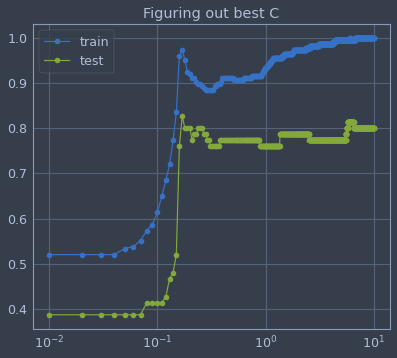

In [39]:
plt.figure(figsize=(10,10))
plt.plot(Cs, score_train, 'o-', label="train")
plt.plot(Cs, score_test, 'o-', label="test")
plt.legend()
plt.xscale('log')
plt.title("Figuring out best C")
plt.plot

**Considerazioni**: c'è un leggero overfitting del modello, ma si può comunque affermare che i risultati sono più che soddisfacienti. La SVM ottiene una accuracy praticamente del 100% sui dati ti training, ovvero riesce a dividere perfettamente l'iperspazio 100-dimensionale. A quanto pare, la divisione dello spazio è molto valida anche per i dati di test, sui quali si riscontra solamente un piccolo errore (si arriva ad ottenere una accuracu sopra il 95%).

È importante notare come, possedendo questi addestramenti elementi stocastici, si dovrebbe procedere eseguendo *k-fold cross validation*.

Dal grafico si può notare come un valore $C > 5$ sia più che soddisfaciente.

**Cose per prof**:
- Abbiamo trovato un lessico: facciamoglielo vedere e chiedere parere.
- Dire che ci focalizziamo nel far vedere le diverse tecniche di Score Induction: senza induction, Hamilton, Nicoli e, se riusciamo, altro. Magari proviamo, per Nicoli, diversi algoritmi di ML.
- Chiedere se va bene fare anche una consistente Data Augmentation. Per esempio, da 100 a 1000.

## Propagation

**NOTA IMPORTANTE**: per ottenere degli intervalli di confidenza, possiamo usare il Bootstrapping proposto da Hamilton.

In [41]:
# Addestriamo completamente il lessico
inducer = svm.SVC(C = 10, kernel = 'poly', gamma='auto').fit(X,y)

In [42]:
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [54]:
models_test = [slices["New York Times"], slices["Breitbart"]]

In [44]:
corpora_test = ["./text_New York Times.txt", "./text_Breitbart.txt"]

In [45]:
models_prepagation = [{word: inducer.predict([model.wv[word]])[0] 
  for word in model.wv.vocab} for model in models_test]

In [50]:
my_list = np.array(list(models_prepagation[0].values()))

[]

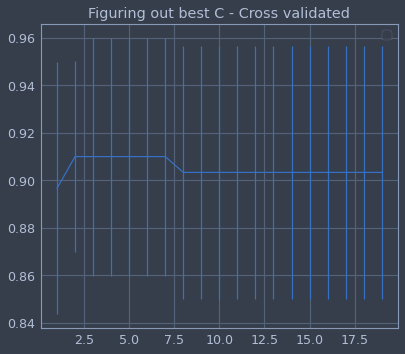

In [40]:
#tento con una cross validation e c nell'arco 0.1, 10
score_mean = []
score_stds = []
Cs = Cs = np.arange(1, 20, 1)
for c in Cs:
    clf = svm.SVC(C=c, kernel = "poly", gamma="auto")
    scores = cross_val_score(clf, X, y, cv=5)
    score_mean.append(scores.mean())
    score_stds.append(scores.std())

plt.errorbar(Cs, score_mean, yerr = score_stds)
plt.legend()
plt.title("Figuring out best C - Cross validated")
plt.plot()

# Il miglior valore è ~15